## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import warnings
warnings.filterwarnings('ignore')

# Progress tracking
from tqdm.auto import tqdm

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import ks_2samp, pearsonr
from scipy.spatial.distance import jensenshannon

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")
print(f"📅 TimeGAN Implementation Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔢 TensorFlow version: {tf.__version__}")
print(f"🎲 Random seed: {SEED}")

✅ Libraries imported successfully!
📅 TimeGAN Implementation Date: 2025-11-21 21:38:07
🔢 TensorFlow version: 2.20.0
🎲 Random seed: 42


## 2. Configuration

In [2]:
# Directories
PROCESSED_DATA_DIR = '../../data/processed'
FEATURE_DATA_DIR = '../../data/features'
MODELS_DIR = '../../models/timegan'
RESULTS_DIR = '../../outputs/results'
FIGURES_DIR = '../../outputs/figures'
SYNTHETIC_DATA_DIR = '../../data/synthetic/timegan'

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(SYNTHETIC_DATA_DIR, exist_ok=True)

# TimeGAN Hyperparameters
CONFIG = {
    # Data parameters
    'seq_len': 24,           # Sequence length (24 trading days ~ 1 month)
    'n_features': None,      # Will be set based on data
    'batch_size': 128,
    
    # Network architecture
    'hidden_dim': 64,        # Hidden dimension for RNN layers
    'num_layers': 3,         # Number of RNN layers
    'z_dim': 64,             # Random noise dimension
    
    # Training parameters
    'iterations': 10000,     # Total training iterations
    'learning_rate': 1e-3,
    
    # Loss weights
    'gamma': 1.0,            # Supervised loss weight
}

# Assets to generate synthetic data for
TEST_ASSETS = ['GSPC', 'IXIC', 'AAPL', 'BTC_USD']

print(f"📂 Models directory: {MODELS_DIR}")
print(f"📂 Synthetic data directory: {SYNTHETIC_DATA_DIR}")
print(f"\n⚙️  TimeGAN Configuration:")
for key, value in CONFIG.items():
    print(f"   {key:20s}: {value}")
print(f"\n🎯 Assets for synthetic generation: {', '.join(TEST_ASSETS)}")

📂 Models directory: ../../models/timegan
📂 Synthetic data directory: ../../data/synthetic/timegan

⚙️  TimeGAN Configuration:
   seq_len             : 24
   n_features          : None
   batch_size          : 128
   hidden_dim          : 64
   num_layers          : 3
   z_dim               : 64
   iterations          : 10000
   learning_rate       : 0.001
   gamma               : 1.0

🎯 Assets for synthetic generation: GSPC, IXIC, AAPL, BTC_USD


## 3. Data Loading and Preprocessing

In [14]:
def load_and_prepare_data(ticker, use_features=True):
    """
    Load and prepare data for TimeGAN training.
    
    Parameters:
    -----------
    ticker : str
        Asset ticker symbol
    use_features : bool
        If True, use engineered features; if False, use only returns
    
    Returns:
    --------
    data_scaled : np.ndarray
        Normalized data ready for TimeGAN
    scaler : MinMaxScaler
        Fitted scaler for inverse transform
    feature_names : list
        Names of features used
    """
    print(f"\n📥 Loading data for {ticker}...")
    
    if use_features:
        # Load engineered features
        data = pd.read_csv(os.path.join(FEATURE_DATA_DIR, f"{ticker}_features.csv"), 
                          index_col=0, parse_dates=True)
        
        # Select important features (exclude highly correlated ones)
        feature_cols = [
            'Returns', 'Log_Returns', 'Volume_Change',
            # Momentum
            'RSI', 'MACD', 'MACD_Signal', 'Stochastic_K',
            # Trend  
            'SMA_20', 'EMA_20', 'ADX',
            # Volatility
            'BB_Width', 'ATR', 'Historical_Vol',
            # Lagged features
            'Returns_Lag_1', 'Returns_Lag_5',
            # Rolling statistics
            'Returns_Rolling_Mean_5', 'Returns_Rolling_Std_5',
            'Returns_Rolling_Mean_20', 'Returns_Rolling_Std_20'
        ]
        
        # Filter columns that exist
        feature_cols = [col for col in feature_cols if col in data.columns]
        data = data[feature_cols]
        
    else:
        # Use only returns data
        train = pd.read_csv(os.path.join(PROCESSED_DATA_DIR, 'train', f"{ticker}_train.csv"), 
                           index_col=0, parse_dates=True)
        data = train[['Returns']]
        feature_cols = ['Returns']
    
    # Clean data: remove infinities and NaNs
    data = data.replace([np.inf, -np.inf], np.nan)
    data = data.dropna()
    
    print(f"   Shape: {data.shape}")
    print(f"   Features: {len(feature_cols)}")
    print(f"   Date range: {data.index[0]} to {data.index[-1]}")
    
    # Check for remaining issues
    if data.isnull().any().any():
        print(f"   ⚠️  Warning: Still contains NaN values")
    if np.isinf(data.values).any():
        print(f"   ⚠️  Warning: Still contains infinity values")
    
    # Normalize data to [0, 1]
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(data.values)
    
    print(f"   ✅ Data normalized to [{data_scaled.min():.3f}, {data_scaled.max():.3f}]")
    
    return data_scaled, scaler, feature_cols

print("✅ Data loading function defined")

✅ Data loading function defined


## 4. Sequence Creation

In [4]:
def create_sequences(data, seq_len):
    """
    Create overlapping sequences for TimeGAN training.
    
    Parameters:
    -----------
    data : np.ndarray
        Input data of shape (n_samples, n_features)
    seq_len : int
        Length of each sequence
    
    Returns:
    --------
    sequences : np.ndarray
        Array of shape (n_sequences, seq_len, n_features)
    """
    sequences = []
    
    for i in range(len(data) - seq_len + 1):
        sequences.append(data[i:i + seq_len])
    
    sequences = np.array(sequences)
    
    print(f"\n📦 Created {len(sequences):,} sequences")
    print(f"   Sequence shape: {sequences.shape}")
    print(f"   Total parameters per sequence: {seq_len} timesteps × {sequences.shape[2]} features")
    
    return sequences

print("✅ Sequence creation function defined")

✅ Sequence creation function defined


## 5. TimeGAN Architecture

### 5.1 Embedding Network

In [5]:
def build_embedder(seq_len, n_features, hidden_dim, num_layers):
    """
    Build the embedding network (encoder).
    Maps input sequences to latent representations.
    """
    inputs = layers.Input(shape=(seq_len, n_features), name='embedder_input')
    x = inputs
    
    # Stack GRU layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        x = layers.GRU(
            hidden_dim,
            return_sequences=True,  # Always return sequences for TimeGAN
            name=f'embedder_gru_{i+1}'
        )(x)
    
    # Output: latent representation
    outputs = layers.Dense(hidden_dim, activation='sigmoid', name='embedder_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Embedder')
    return model

print("✅ Embedder architecture defined")

✅ Embedder architecture defined


### 5.2 Recovery Network

In [6]:
def build_recovery(seq_len, n_features, hidden_dim, num_layers):
    """
    Build the recovery network (decoder).
    Reconstructs original features from latent representations.
    """
    inputs = layers.Input(shape=(seq_len, hidden_dim), name='recovery_input')
    x = inputs
    
    # Stack GRU layers
    for i in range(num_layers):
        x = layers.GRU(
            hidden_dim,
            return_sequences=True,
            name=f'recovery_gru_{i+1}'
        )(x)
    
    # Output: reconstructed features
    outputs = layers.Dense(n_features, activation='sigmoid', name='recovery_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Recovery')
    return model

print("✅ Recovery architecture defined")

✅ Recovery architecture defined


### 5.3 Generator Network

In [7]:
def build_generator(seq_len, z_dim, hidden_dim, num_layers):
    """
    Build the generator network.
    Generates synthetic latent representations from random noise.
    """
    inputs = layers.Input(shape=(seq_len, z_dim), name='generator_input')
    x = inputs
    
    # Stack GRU layers
    for i in range(num_layers):
        x = layers.GRU(
            hidden_dim,
            return_sequences=True,
            name=f'generator_gru_{i+1}'
        )(x)
    
    # Output: synthetic latent representation
    outputs = layers.Dense(hidden_dim, activation='sigmoid', name='generator_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Generator')
    return model

print("✅ Generator architecture defined")

✅ Generator architecture defined


### 5.4 Discriminator Network

In [8]:
def build_discriminator(seq_len, hidden_dim, num_layers):
    """
    Build the discriminator network.
    Distinguishes real from synthetic latent representations.
    """
    inputs = layers.Input(shape=(seq_len, hidden_dim), name='discriminator_input')
    x = inputs
    
    # Stack GRU layers
    for i in range(num_layers):
        return_sequences = (i < num_layers - 1)
        x = layers.GRU(
            hidden_dim,
            return_sequences=return_sequences,
            name=f'discriminator_gru_{i+1}'
        )(x)
    
    # Output: probability of being real
    outputs = layers.Dense(1, activation='sigmoid', name='discriminator_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Discriminator')
    return model

print("✅ Discriminator architecture defined")

✅ Discriminator architecture defined


### 5.5 Supervisor Network

In [9]:
def build_supervisor(seq_len, hidden_dim, num_layers):
    """
    Build the supervisor network.
    Ensures temporal consistency in latent space by predicting next timestep.
    """
    inputs = layers.Input(shape=(seq_len - 1, hidden_dim), name='supervisor_input')
    x = inputs
    
    # Stack GRU layers (fewer than other networks)
    for i in range(num_layers - 1):
        x = layers.GRU(
            hidden_dim,
            return_sequences=True,
            name=f'supervisor_gru_{i+1}'
        )(x)
    
    # Output: predicted next latent representation
    outputs = layers.Dense(hidden_dim, activation='sigmoid', name='supervisor_output')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='Supervisor')
    return model

print("✅ Supervisor architecture defined")

✅ Supervisor architecture defined


## 6. TimeGAN Training Class

In [10]:
class TimeGAN:
    """
    TimeGAN implementation for financial time-series generation.
    """
    
    def __init__(self, config):
        self.config = config
        self.seq_len = config['seq_len']
        self.n_features = config['n_features']
        self.hidden_dim = config['hidden_dim']
        self.num_layers = config['num_layers']
        self.z_dim = config['z_dim']
        self.batch_size = config['batch_size']
        self.learning_rate = config['learning_rate']
        self.gamma = config['gamma']
        
        # Build networks
        self._build_networks()
        
        # Initialize optimizers
        self.embedder_optimizer = Adam(learning_rate=self.learning_rate)
        self.recovery_optimizer = Adam(learning_rate=self.learning_rate)
        self.supervisor_optimizer = Adam(learning_rate=self.learning_rate)
        self.generator_optimizer = Adam(learning_rate=self.learning_rate)
        self.discriminator_optimizer = Adam(learning_rate=self.learning_rate)
        
        # Loss functions
        self.mse_loss = MeanSquaredError()
        self.bce_loss = BinaryCrossentropy()
        
        print("\n✅ TimeGAN initialized")
        self._print_model_summary()
    
    def _build_networks(self):
        """Build all TimeGAN networks."""
        print("\n🏗️  Building TimeGAN networks...")
        
        self.embedder = build_embedder(
            self.seq_len, self.n_features, self.hidden_dim, self.num_layers
        )
        
        self.recovery = build_recovery(
            self.seq_len, self.n_features, self.hidden_dim, self.num_layers
        )
        
        self.generator = build_generator(
            self.seq_len, self.z_dim, self.hidden_dim, self.num_layers
        )
        
        self.discriminator = build_discriminator(
            self.seq_len, self.hidden_dim, self.num_layers
        )
        
        self.supervisor = build_supervisor(
            self.seq_len, self.hidden_dim, self.num_layers
        )
    
    def _print_model_summary(self):
        """Print parameter counts for all networks."""
        print("\n📊 Network Parameters:")
        print(f"   Embedder:      {self.embedder.count_params():,}")
        print(f"   Recovery:      {self.recovery.count_params():,}")
        print(f"   Generator:     {self.generator.count_params():,}")
        print(f"   Discriminator: {self.discriminator.count_params():,}")
        print(f"   Supervisor:    {self.supervisor.count_params():,}")
        total = sum([
            self.embedder.count_params(),
            self.recovery.count_params(),
            self.generator.count_params(),
            self.discriminator.count_params(),
            self.supervisor.count_params()
        ])
        print(f"   {'='*30}")
        print(f"   TOTAL:         {total:,}")
    
    def generate_noise(self, batch_size):
        """Generate random noise for generator input."""
        return np.random.uniform(0, 1, size=(batch_size, self.seq_len, self.z_dim))
    
    @tf.function
    def train_autoencoder_step(self, X_batch):
        """Training step for autoencoder (embedder + recovery)."""
        with tf.GradientTape() as tape:
            # Embed and reconstruct
            H = self.embedder(X_batch, training=True)
            X_recon = self.recovery(H, training=True)
            
            # Reconstruction loss
            loss = self.mse_loss(X_batch, X_recon)
        
        # Update weights
        variables = self.embedder.trainable_variables + self.recovery.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.embedder_optimizer.apply_gradients(zip(gradients[:len(self.embedder.trainable_variables)], 
                                                     self.embedder.trainable_variables))
        self.recovery_optimizer.apply_gradients(zip(gradients[len(self.embedder.trainable_variables):], 
                                                     self.recovery.trainable_variables))
        
        return loss
    
    @tf.function
    def train_supervisor_step(self, X_batch):
        """Training step for supervisor."""
        with tf.GradientTape() as tape:
            # Embed sequences
            H = self.embedder(X_batch, training=True)
            
            # Supervisor predicts next step
            H_supervise = self.supervisor(H[:, :-1, :], training=True)
            
            # Supervised loss
            loss = self.mse_loss(H[:, 1:, :], H_supervise)
        
        # Update supervisor
        gradients = tape.gradient(loss, self.supervisor.trainable_variables)
        self.supervisor_optimizer.apply_gradients(zip(gradients, self.supervisor.trainable_variables))
        
        return loss
    
    @tf.function
    def train_generator_step(self, X_batch, Z_batch):
        """Training step for generator."""
        with tf.GradientTape() as tape:
            # Generate synthetic latent representations
            H_fake = self.generator(Z_batch, training=True)
            H_supervise = self.supervisor(H_fake[:, :-1, :], training=True)
            
            # Discriminator's opinion on fake data
            Y_fake = self.discriminator(H_fake, training=False)
            
            # Generator wants discriminator to think fake is real
            adversarial_loss = self.bce_loss(tf.ones_like(Y_fake), Y_fake)
            
            # Supervised loss (temporal consistency)
            supervised_loss = self.mse_loss(H_fake[:, 1:, :], H_supervise)
            
            # Total generator loss
            loss = adversarial_loss + self.gamma * supervised_loss
        
        # Update generator and supervisor
        variables = self.generator.trainable_variables + self.supervisor.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.generator_optimizer.apply_gradients(zip(gradients[:len(self.generator.trainable_variables)], 
                                                      self.generator.trainable_variables))
        self.supervisor_optimizer.apply_gradients(zip(gradients[len(self.generator.trainable_variables):], 
                                                       self.supervisor.trainable_variables))
        
        return loss, adversarial_loss, supervised_loss
    
    @tf.function
    def train_discriminator_step(self, X_batch, Z_batch):
        """Training step for discriminator."""
        with tf.GradientTape() as tape:
            # Real data
            H_real = self.embedder(X_batch, training=True)
            Y_real = self.discriminator(H_real, training=True)
            
            # Fake data
            H_fake = self.generator(Z_batch, training=True)
            Y_fake = self.discriminator(H_fake, training=True)
            
            # Discriminator loss
            real_loss = self.bce_loss(tf.ones_like(Y_real), Y_real)
            fake_loss = self.bce_loss(tf.zeros_like(Y_fake), Y_fake)
            loss = real_loss + fake_loss
        
        # Update discriminator
        gradients = tape.gradient(loss, self.discriminator.trainable_variables)
        self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_variables))
        
        return loss, real_loss, fake_loss
    
    def train(self, X_train, iterations):
        """
        Train TimeGAN with three phases:
        1. Autoencoder (embedder + recovery)
        2. Supervised (supervisor)
        3. Joint (generator + discriminator + all)
        """
        n_samples = X_train.shape[0]
        
        # Phase 1: Autoencoder training
        print("\n" + "="*80)
        print("PHASE 1: AUTOENCODER TRAINING")
        print("="*80)
        
        ae_iterations = iterations // 4
        for step in tqdm(range(ae_iterations), desc="Training Autoencoder"):
            # Sample batch
            idx = np.random.randint(0, n_samples, self.batch_size)
            X_batch = X_train[idx]
            
            # Train step
            loss = self.train_autoencoder_step(X_batch)
            
            # Log progress
            if (step + 1) % 500 == 0:
                print(f"   Step {step+1}/{ae_iterations} - Reconstruction Loss: {loss:.6f}")
        
        # Phase 2: Supervisor training
        print("\n" + "="*80)
        print("PHASE 2: SUPERVISOR TRAINING")
        print("="*80)
        
        sup_iterations = iterations // 4
        for step in tqdm(range(sup_iterations), desc="Training Supervisor"):
            # Sample batch
            idx = np.random.randint(0, n_samples, self.batch_size)
            X_batch = X_train[idx]
            
            # Train step
            loss = self.train_supervisor_step(X_batch)
            
            # Log progress
            if (step + 1) % 500 == 0:
                print(f"   Step {step+1}/{sup_iterations} - Supervised Loss: {loss:.6f}")
        
        # Phase 3: Joint training
        print("\n" + "="*80)
        print("PHASE 3: JOINT GAN TRAINING")
        print("="*80)
        
        joint_iterations = iterations // 2
        for step in tqdm(range(joint_iterations), desc="Joint Training"):
            # Sample batch
            idx = np.random.randint(0, n_samples, self.batch_size)
            X_batch = X_train[idx]
            Z_batch = self.generate_noise(self.batch_size)
            
            # Train generator (2 steps)
            for _ in range(2):
                g_loss, g_adv_loss, g_sup_loss = self.train_generator_step(X_batch, Z_batch)
            
            # Train discriminator (1 step)
            d_loss, d_real_loss, d_fake_loss = self.train_discriminator_step(X_batch, Z_batch)
            
            # Log progress
            if (step + 1) % 500 == 0:
                print(f"\n   Step {step+1}/{joint_iterations}")
                print(f"      Generator - Total: {g_loss:.6f}, Adversarial: {g_adv_loss:.6f}, Supervised: {g_sup_loss:.6f}")
                print(f"      Discriminator - Total: {d_loss:.6f}, Real: {d_real_loss:.6f}, Fake: {d_fake_loss:.6f}")
        
        print("\n" + "="*80)
        print("✅ TRAINING COMPLETE!")
        print("="*80)
    
    def generate_samples(self, n_samples):
        """
        Generate synthetic samples.
        """
        # Generate random noise
        Z = self.generate_noise(n_samples)
        
        # Generate latent representations
        H_fake = self.generator(Z, training=False)
        
        # Recover to original feature space
        X_fake = self.recovery(H_fake, training=False)
        
        return X_fake.numpy()
    
    def save_models(self, save_dir):
        """Save all trained models."""
        os.makedirs(save_dir, exist_ok=True)
        
        self.embedder.save(os.path.join(save_dir, 'embedder.h5'))
        self.recovery.save(os.path.join(save_dir, 'recovery.h5'))
        self.generator.save(os.path.join(save_dir, 'generator.h5'))
        self.discriminator.save(os.path.join(save_dir, 'discriminator.h5'))
        self.supervisor.save(os.path.join(save_dir, 'supervisor.h5'))
        
        print(f"\n💾 Models saved to {save_dir}")

print("✅ TimeGAN class defined")

✅ TimeGAN class defined


## 7. Evaluation Metrics

In [11]:
def evaluate_synthetic_data(real_data, synthetic_data, feature_names):
    """
    Comprehensive evaluation of synthetic data quality.
    
    Metrics:
    - Distributional similarity (KS test, JS divergence)
    - Statistical properties (mean, std, skewness, kurtosis)
    - Temporal properties (autocorrelation)
    - Correlations between features
    """
    results = {}
    
    print("\n" + "="*80)
    print("SYNTHETIC DATA EVALUATION")
    print("="*80)
    
    # 1. Distributional Similarity
    print("\n📊 1. DISTRIBUTIONAL SIMILARITY (KS Test)")
    print("-" * 80)
    ks_stats = []
    ks_pvalues = []
    
    for i, feat in enumerate(feature_names):
        # Flatten sequences for distribution comparison
        real_feat = real_data[:, :, i].flatten()
        synth_feat = synthetic_data[:, :, i].flatten()
        
        # KS test
        ks_stat, ks_pval = ks_2samp(real_feat, synth_feat)
        ks_stats.append(ks_stat)
        ks_pvalues.append(ks_pval)
        
        print(f"   {feat:30s} - KS stat: {ks_stat:.4f}, p-value: {ks_pval:.4f}")
    
    results['ks_stats'] = ks_stats
    results['ks_pvalues'] = ks_pvalues
    print(f"\n   Average KS statistic: {np.mean(ks_stats):.4f} (lower is better)")
    
    # 2. Statistical Properties
    print("\n📈 2. STATISTICAL PROPERTIES")
    print("-" * 80)
    
    stat_comparison = []
    for i, feat in enumerate(feature_names):
        real_feat = real_data[:, :, i].flatten()
        synth_feat = synthetic_data[:, :, i].flatten()
        
        real_mean, synth_mean = np.mean(real_feat), np.mean(synth_feat)
        real_std, synth_std = np.std(real_feat), np.std(synth_feat)
        
        stat_comparison.append({
            'Feature': feat,
            'Real_Mean': real_mean,
            'Synth_Mean': synth_mean,
            'Mean_Diff': abs(real_mean - synth_mean),
            'Real_Std': real_std,
            'Synth_Std': synth_std,
            'Std_Diff': abs(real_std - synth_std)
        })
    
    stat_df = pd.DataFrame(stat_comparison)
    print(stat_df.to_string(index=False))
    results['statistics'] = stat_df
    
    # 3. Autocorrelation
    print("\n🔄 3. TEMPORAL PROPERTIES (Autocorrelation at lag 1)")
    print("-" * 80)
    
    autocorr_comparison = []
    for i, feat in enumerate(feature_names[:5]):  # Check first 5 features
        real_feat = real_data[:, :, i].flatten()
        synth_feat = synthetic_data[:, :, i].flatten()
        
        real_autocorr = pd.Series(real_feat).autocorr(lag=1)
        synth_autocorr = pd.Series(synth_feat).autocorr(lag=1)
        
        autocorr_comparison.append({
            'Feature': feat,
            'Real_ACF': real_autocorr,
            'Synth_ACF': synth_autocorr,
            'Diff': abs(real_autocorr - synth_autocorr)
        })
    
    autocorr_df = pd.DataFrame(autocorr_comparison)
    print(autocorr_df.to_string(index=False))
    results['autocorrelation'] = autocorr_df
    
    # 4. Cross-correlations
    if len(feature_names) > 1:
        print("\n🔗 4. FEATURE CORRELATIONS")
        print("-" * 80)
        
        # Compute correlation matrices
        real_corr = np.corrcoef(real_data.reshape(-1, len(feature_names)).T)
        synth_corr = np.corrcoef(synthetic_data.reshape(-1, len(feature_names)).T)
        
        corr_diff = np.abs(real_corr - synth_corr)
        print(f"   Average correlation difference: {np.mean(corr_diff):.4f}")
        print(f"   Max correlation difference: {np.max(corr_diff):.4f}")
        
        results['correlation_diff'] = corr_diff
    
    print("\n" + "="*80)
    print("✅ EVALUATION COMPLETE")
    print("="*80)
    
    return results

print("✅ Evaluation function defined")

✅ Evaluation function defined


## 8. Visualization Functions

In [12]:
def visualize_synthetic_data(real_data, synthetic_data, feature_names, ticker, save_path=None):
    """
    Create comprehensive visualizations comparing real and synthetic data.
    """
    n_features_to_plot = min(4, len(feature_names))
    
    fig, axes = plt.subplots(n_features_to_plot, 3, figsize=(20, 4*n_features_to_plot))
    
    if n_features_to_plot == 1:
        axes = axes.reshape(1, -1)
    
    for i in range(n_features_to_plot):
        feat_name = feature_names[i]
        
        # Extract feature data
        real_feat = real_data[:, :, i].flatten()
        synth_feat = synthetic_data[:, :, i].flatten()
        
        # Plot 1: Time series comparison
        ax = axes[i, 0]
        n_samples_to_plot = min(500, len(real_feat))
        ax.plot(real_feat[:n_samples_to_plot], label='Real', alpha=0.7, linewidth=1)
        ax.plot(synth_feat[:n_samples_to_plot], label='Synthetic', alpha=0.7, linewidth=1)
        ax.set_title(f'{feat_name} - Time Series', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 2: Distribution comparison
        ax = axes[i, 1]
        ax.hist(real_feat, bins=50, alpha=0.6, label='Real', density=True, color='blue')
        ax.hist(synth_feat, bins=50, alpha=0.6, label='Synthetic', density=True, color='orange')
        ax.set_title(f'{feat_name} - Distribution', fontsize=12, fontweight='bold')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Plot 3: Q-Q plot
        ax = axes[i, 2]
        real_sorted = np.sort(real_feat)
        synth_sorted = np.sort(synth_feat)
        n_quantiles = min(len(real_sorted), len(synth_sorted))
        ax.scatter(real_sorted[:n_quantiles], synth_sorted[:n_quantiles], alpha=0.3, s=1)
        ax.plot([real_sorted.min(), real_sorted.max()], 
               [real_sorted.min(), real_sorted.max()], 
               'r--', linewidth=2, label='Perfect Match')
        ax.set_title(f'{feat_name} - Q-Q Plot', fontsize=12, fontweight='bold')
        ax.set_xlabel('Real Quantiles')
        ax.set_ylabel('Synthetic Quantiles')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{ticker} - Real vs Synthetic Data Comparison', 
                fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\n💾 Visualization saved to {save_path}")
    
    plt.show()

print("✅ Visualization function defined")

✅ Visualization function defined


## 9. Train TimeGAN on Selected Assets

In [15]:
# Select first asset for demonstration
ticker = TEST_ASSETS[0]

print("="*80)
print(f"TRAINING TIMEGAN ON {ticker}")
print("="*80)

# Load and prepare data
data_scaled, scaler, feature_names = load_and_prepare_data(ticker, use_features=True)

# Create sequences
sequences = create_sequences(data_scaled, CONFIG['seq_len'])

# Update config with actual number of features
CONFIG['n_features'] = sequences.shape[2]

print(f"\n✅ Data prepared for TimeGAN training")
print(f"   Sequences: {sequences.shape[0]:,}")
print(f"   Sequence length: {sequences.shape[1]}")
print(f"   Features: {sequences.shape[2]}")

TRAINING TIMEGAN ON GSPC

📥 Loading data for GSPC...
   Shape: (2480, 11)
   Features: 11
   Date range: 2015-02-23 00:00:00 to 2024-12-30 00:00:00
   ✅ Data normalized to [0.000, 1.000]

📦 Created 2,457 sequences
   Sequence shape: (2457, 24, 11)
   Total parameters per sequence: 24 timesteps × 11 features

✅ Data prepared for TimeGAN training
   Sequences: 2,457
   Sequence length: 24
   Features: 11


In [16]:
# Initialize TimeGAN
timegan = TimeGAN(CONFIG)


🏗️  Building TimeGAN networks...

✅ TimeGAN initialized

📊 Network Parameters:
   Embedder:      68,864
   Recovery:      75,595
   Generator:     79,040
   Discriminator: 74,945
   Supervisor:    54,080
   TOTAL:         352,524


In [17]:
# Train TimeGAN
timegan.train(sequences, iterations=CONFIG['iterations'])


PHASE 1: AUTOENCODER TRAINING


Training Autoencoder:   0%|          | 0/2500 [00:00<?, ?it/s]

   Step 500/2500 - Reconstruction Loss: 0.001602
   Step 1000/2500 - Reconstruction Loss: 0.000748
   Step 1000/2500 - Reconstruction Loss: 0.000748
   Step 1500/2500 - Reconstruction Loss: 0.000328
   Step 1500/2500 - Reconstruction Loss: 0.000328
   Step 2000/2500 - Reconstruction Loss: 0.000211
   Step 2000/2500 - Reconstruction Loss: 0.000211
   Step 2500/2500 - Reconstruction Loss: 0.000197

PHASE 2: SUPERVISOR TRAINING
   Step 2500/2500 - Reconstruction Loss: 0.000197

PHASE 2: SUPERVISOR TRAINING


Training Supervisor:   0%|          | 0/2500 [00:00<?, ?it/s]

   Step 500/2500 - Supervised Loss: 0.000872
   Step 1000/2500 - Supervised Loss: 0.000994
   Step 1000/2500 - Supervised Loss: 0.000994
   Step 1500/2500 - Supervised Loss: 0.000756
   Step 1500/2500 - Supervised Loss: 0.000756
   Step 2000/2500 - Supervised Loss: 0.000566
   Step 2000/2500 - Supervised Loss: 0.000566
   Step 2500/2500 - Supervised Loss: 0.000622

PHASE 3: JOINT GAN TRAINING
   Step 2500/2500 - Supervised Loss: 0.000622

PHASE 3: JOINT GAN TRAINING


Joint Training:   0%|          | 0/5000 [00:00<?, ?it/s]


   Step 500/5000
      Generator - Total: 0.595295, Adversarial: 0.589497, Supervised: 0.005798
      Discriminator - Total: 1.576677, Real: 0.763617, Fake: 0.813061

   Step 1000/5000
      Generator - Total: 0.695457, Adversarial: 0.695274, Supervised: 0.000183
      Discriminator - Total: 1.383811, Real: 0.692718, Fake: 0.691094

   Step 1000/5000
      Generator - Total: 0.695457, Adversarial: 0.695274, Supervised: 0.000183
      Discriminator - Total: 1.383811, Real: 0.692718, Fake: 0.691094

   Step 1500/5000
      Generator - Total: 0.691094, Adversarial: 0.690714, Supervised: 0.000380
      Discriminator - Total: 1.393514, Real: 0.697509, Fake: 0.696005

   Step 1500/5000
      Generator - Total: 0.691094, Adversarial: 0.690714, Supervised: 0.000380
      Discriminator - Total: 1.393514, Real: 0.697509, Fake: 0.696005

   Step 2000/5000
      Generator - Total: 0.693299, Adversarial: 0.693269, Supervised: 0.000030
      Discriminator - Total: 1.386041, Real: 0.693000, Fake: 0.

## 10. Generate Synthetic Data

In [18]:
# Generate synthetic samples
n_synthetic_samples = len(sequences)

print(f"\n🎨 Generating {n_synthetic_samples:,} synthetic samples...")
synthetic_data = timegan.generate_samples(n_synthetic_samples)

print(f"✅ Synthetic data generated!")
print(f"   Shape: {synthetic_data.shape}")
print(f"   Range: [{synthetic_data.min():.3f}, {synthetic_data.max():.3f}]")


🎨 Generating 2,457 synthetic samples...
✅ Synthetic data generated!
   Shape: (2457, 24, 11)
   Range: [0.044, 0.870]
✅ Synthetic data generated!
   Shape: (2457, 24, 11)
   Range: [0.044, 0.870]


## 11. Evaluate Synthetic Data Quality

In [19]:
# Evaluate synthetic data
evaluation_results = evaluate_synthetic_data(sequences, synthetic_data, feature_names)


SYNTHETIC DATA EVALUATION

📊 1. DISTRIBUTIONAL SIMILARITY (KS Test)
--------------------------------------------------------------------------------
   Returns                        - KS stat: 0.8853, p-value: 0.0000
   Log_Returns                    - KS stat: 0.8821, p-value: 0.0000
   Volume_Change                  - KS stat: 0.5215, p-value: 0.0000
   MACD                           - KS stat: 0.5675, p-value: 0.0000
   MACD_Signal                    - KS stat: 0.4435, p-value: 0.0000
   SMA_20                         - KS stat: 0.4291, p-value: 0.0000
   EMA_20                         - KS stat: 0.4350, p-value: 0.0000
   ADX                            - KS stat: 0.6939, p-value: 0.0000
   BB_Width                       - KS stat: 0.6553, p-value: 0.0000
   Returns_Lag_1                  - KS stat: 0.8217, p-value: 0.0000
   Returns_Lag_5                  - KS stat: 0.8268, p-value: 0.0000

   Average KS statistic: 0.6511 (lower is better)

📈 2. STATISTICAL PROPERTIES
-----------


💾 Visualization saved to ../../outputs/figures\07_timegan_comparison_GSPC.png


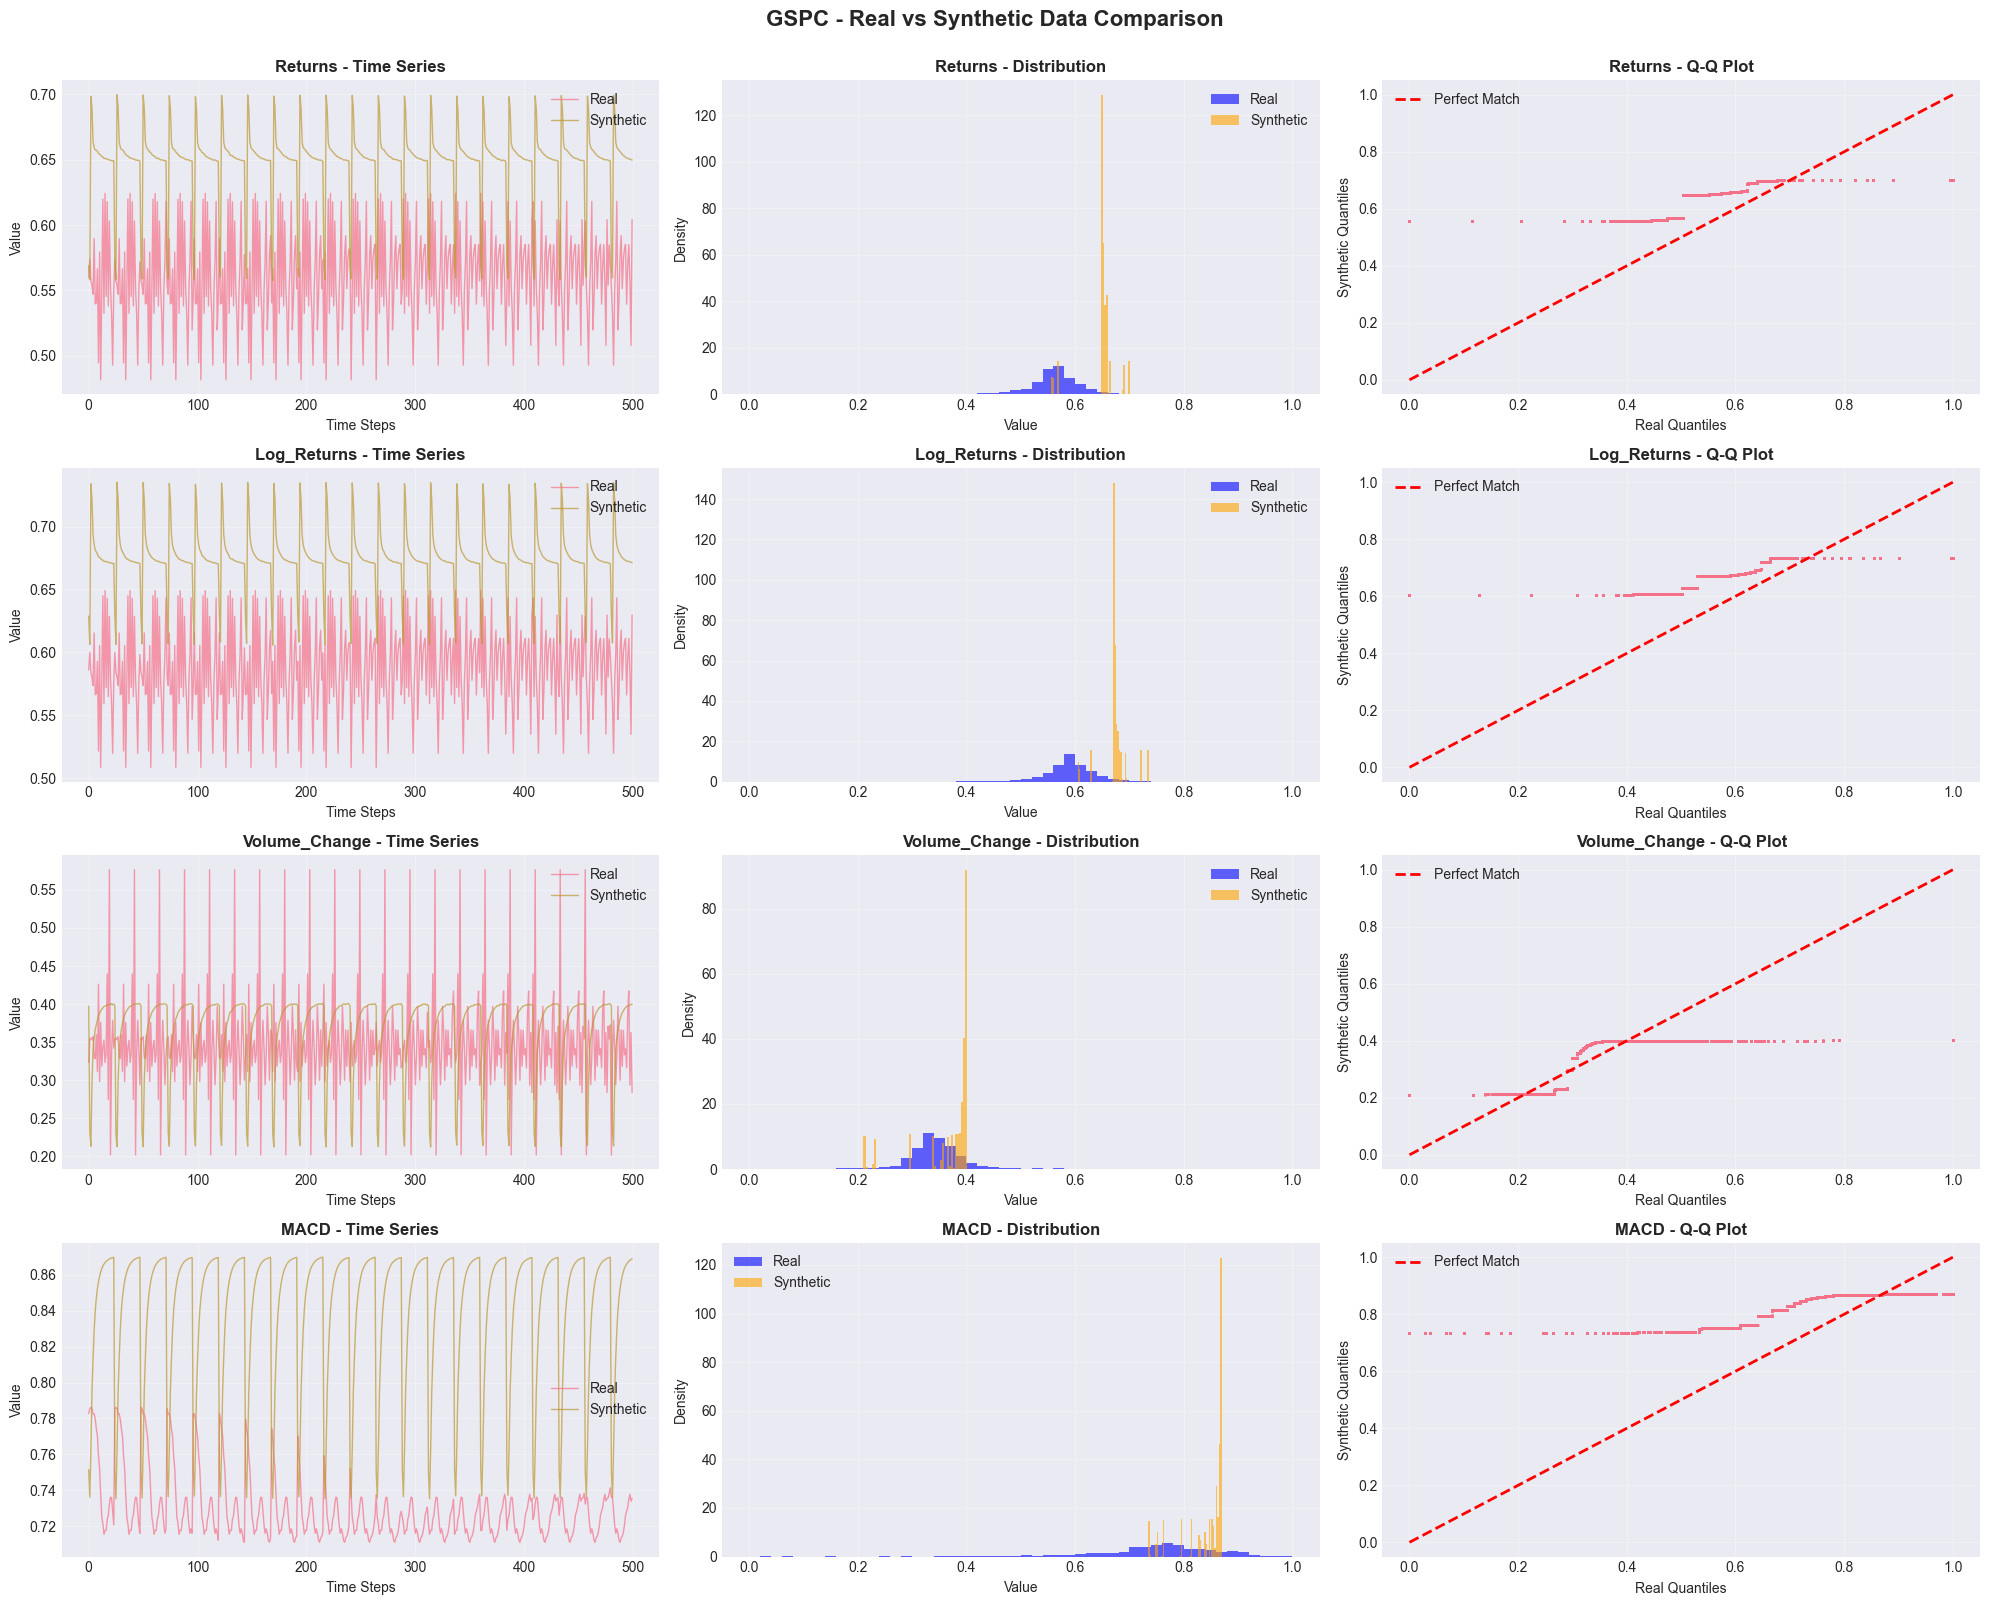

In [20]:
# Visualize results
save_path = os.path.join(FIGURES_DIR, f'07_timegan_comparison_{ticker}.png')
visualize_synthetic_data(sequences, synthetic_data, feature_names, ticker, save_path)

## 12. Save Results

In [21]:
# Save trained models
model_save_dir = os.path.join(MODELS_DIR, ticker)
timegan.save_models(model_save_dir)

# Save synthetic data
synthetic_df = pd.DataFrame(
    synthetic_data.reshape(-1, len(feature_names)),
    columns=feature_names
)
synthetic_save_path = os.path.join(SYNTHETIC_DATA_DIR, f"{ticker}_synthetic.csv")
synthetic_df.to_csv(synthetic_save_path, index=False)
print(f"\n💾 Synthetic data saved to {synthetic_save_path}")

# Save evaluation results
eval_save_path = os.path.join(RESULTS_DIR, f'timegan_evaluation_{ticker}.csv')
evaluation_results['statistics'].to_csv(eval_save_path, index=False)
print(f"💾 Evaluation results saved to {eval_save_path}")


💾 Models saved to ../../models/timegan\GSPC

💾 Synthetic data saved to ../../data/synthetic/timegan\GSPC_synthetic.csv
💾 Evaluation results saved to ../../outputs/results\timegan_evaluation_GSPC.csv

💾 Synthetic data saved to ../../data/synthetic/timegan\GSPC_synthetic.csv
💾 Evaluation results saved to ../../outputs/results\timegan_evaluation_GSPC.csv


## 13. Summary and Next Steps

In [22]:
print("="*80)
print("🎯 TIMEGAN IMPLEMENTATION - SUMMARY")
print("="*80)

print(f"\n✅ COMPLETED TASKS:")
print(f"   1. Implemented TimeGAN architecture with 5 networks")
print(f"   2. Trained on {ticker} with {len(sequences):,} sequences")
print(f"   3. Generated {n_synthetic_samples:,} synthetic samples")
print(f"   4. Evaluated data quality with multiple metrics")
print(f"   5. Saved models and synthetic data")

print(f"\n📊 KEY METRICS:")
avg_ks = np.mean(evaluation_results['ks_stats'])
print(f"   Average KS Statistic: {avg_ks:.4f} (lower is better, < 0.1 is good)")

mean_diff = evaluation_results['statistics']['Mean_Diff'].mean()
std_diff = evaluation_results['statistics']['Std_Diff'].mean()
print(f"   Average Mean Difference: {mean_diff:.6f}")
print(f"   Average Std Difference: {std_diff:.6f}")

if 'correlation_diff' in evaluation_results:
    avg_corr_diff = np.mean(evaluation_results['correlation_diff'])
    print(f"   Average Correlation Difference: {avg_corr_diff:.4f}")

print(f"\n🎯 NEXT STEPS:")
print(f"   1. Train TimeGAN on remaining assets: {', '.join(TEST_ASSETS[1:])}")
print(f"   2. Implement Diffusion model for comparison")
print(f"   3. Use synthetic data for downstream tasks (forecasting)")
print(f"   4. Compare TimeGAN vs Diffusion vs Real data")
print(f"   5. Evaluate data augmentation benefits")

print("\n" + "="*80)
print("✅ TIMEGAN IMPLEMENTATION COMPLETE!")
print("="*80)

🎯 TIMEGAN IMPLEMENTATION - SUMMARY

✅ COMPLETED TASKS:
   1. Implemented TimeGAN architecture with 5 networks
   2. Trained on GSPC with 2,457 sequences
   3. Generated 2,457 synthetic samples
   4. Evaluated data quality with multiple metrics
   5. Saved models and synthetic data

📊 KEY METRICS:
   Average KS Statistic: 0.6511 (lower is better, < 0.1 is good)
   Average Mean Difference: 0.072389
   Average Std Difference: 0.079971
   Average Correlation Difference: 0.4256

🎯 NEXT STEPS:
   1. Train TimeGAN on remaining assets: IXIC, AAPL, BTC_USD
   2. Implement Diffusion model for comparison
   3. Use synthetic data for downstream tasks (forecasting)
   4. Compare TimeGAN vs Diffusion vs Real data
   5. Evaluate data augmentation benefits

✅ TIMEGAN IMPLEMENTATION COMPLETE!
